In [18]:
%matplotlib inline
import os
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import json

from pycocotools import mask
from skimage import measure
from skimage.morphology import dilation, square
from scipy import ndimage
import cv2

In [58]:
data_root = '/home/fothar/data/vis/'

with open(os.path.join(data_root, 'annotations/instances_train_sub.json')) as json_file:
    vis_data = json.load(json_file)

In [60]:
print('vis_data', vis_data.keys())
print('videos', vis_data['videos'][0].keys())
print('annotations', vis_data['annotations'][0].keys())
#print('segmentations', vis_data['annotations'][0]['segmentations'])

vis_data dict_keys(['info', 'licenses', 'videos', 'categories', 'annotations'])
videos dict_keys(['width', 'length', 'date_captured', 'license', 'flickr_url', 'file_names', 'id', 'coco_url', 'height'])
annotations dict_keys(['height', 'width', 'length', 'category_id', 'segmentations', 'bboxes', 'video_id', 'iscrowd', 'id', 'areas'])


In [107]:
print('videos', vis_data['videos'][0].keys())
print('videos', vis_data['videos'][0]['file_names'])
print('annotations', vis_data['annotations'][0]['segmentations'][10])

videos dict_keys(['width', 'length', 'date_captured', 'license', 'flickr_url', 'file_names', 'id', 'coco_url', 'height'])
videos ['0043f083b5/00000.jpg', '0043f083b5/00005.jpg', '0043f083b5/00010.jpg', '0043f083b5/00015.jpg', '0043f083b5/00020.jpg', '0043f083b5/00025.jpg', '0043f083b5/00030.jpg', '0043f083b5/00035.jpg', '0043f083b5/00040.jpg', '0043f083b5/00045.jpg', '0043f083b5/00050.jpg', '0043f083b5/00055.jpg', '0043f083b5/00060.jpg', '0043f083b5/00065.jpg', '0043f083b5/00070.jpg', '0043f083b5/00075.jpg', '0043f083b5/00080.jpg', '0043f083b5/00085.jpg', '0043f083b5/00090.jpg', '0043f083b5/00095.jpg']
annotations {'counts': [802432, 64, 656, 65, 655, 65, 655, 65, 655, 65, 656, 64, 656, 64, 657, 63, 657, 63, 657, 63, 657, 62, 659, 61, 660, 59, 662, 57, 664, 55, 665, 52, 669, 50, 671, 48, 673, 46, 675, 45, 676, 44, 676, 44, 677, 43, 679, 41, 679, 42, 677, 6, 2, 37, 675, 5, 3, 37, 675, 5, 3, 37, 675, 5, 3, 37, 675, 5, 3, 37, 675, 5, 3, 38, 675, 4, 5, 36, 685, 35, 685, 35, 686, 34, 688, 3

In [40]:
image_dir = "/home/fothar/rats/images"
mask_dir = "/home/fothar/rats/masks"
bg_dir = "/home/fothar/rats/back_ground"

video_dir = "/home/fothar/rats/videos"
video_mask_dir = "/home/fothar/rats/video_masks"

aug_image_dir = "/home/fothar/rats/aug_images"
aug_mask_dir = "/home/fothar/rats/aug_masks"

In [21]:
def imFunc(e):
  return int(e[3:-4])

def maskFunc(e):
  return int(e[5:-4])

def bgFunc(e):
  return int(e[3:-4])

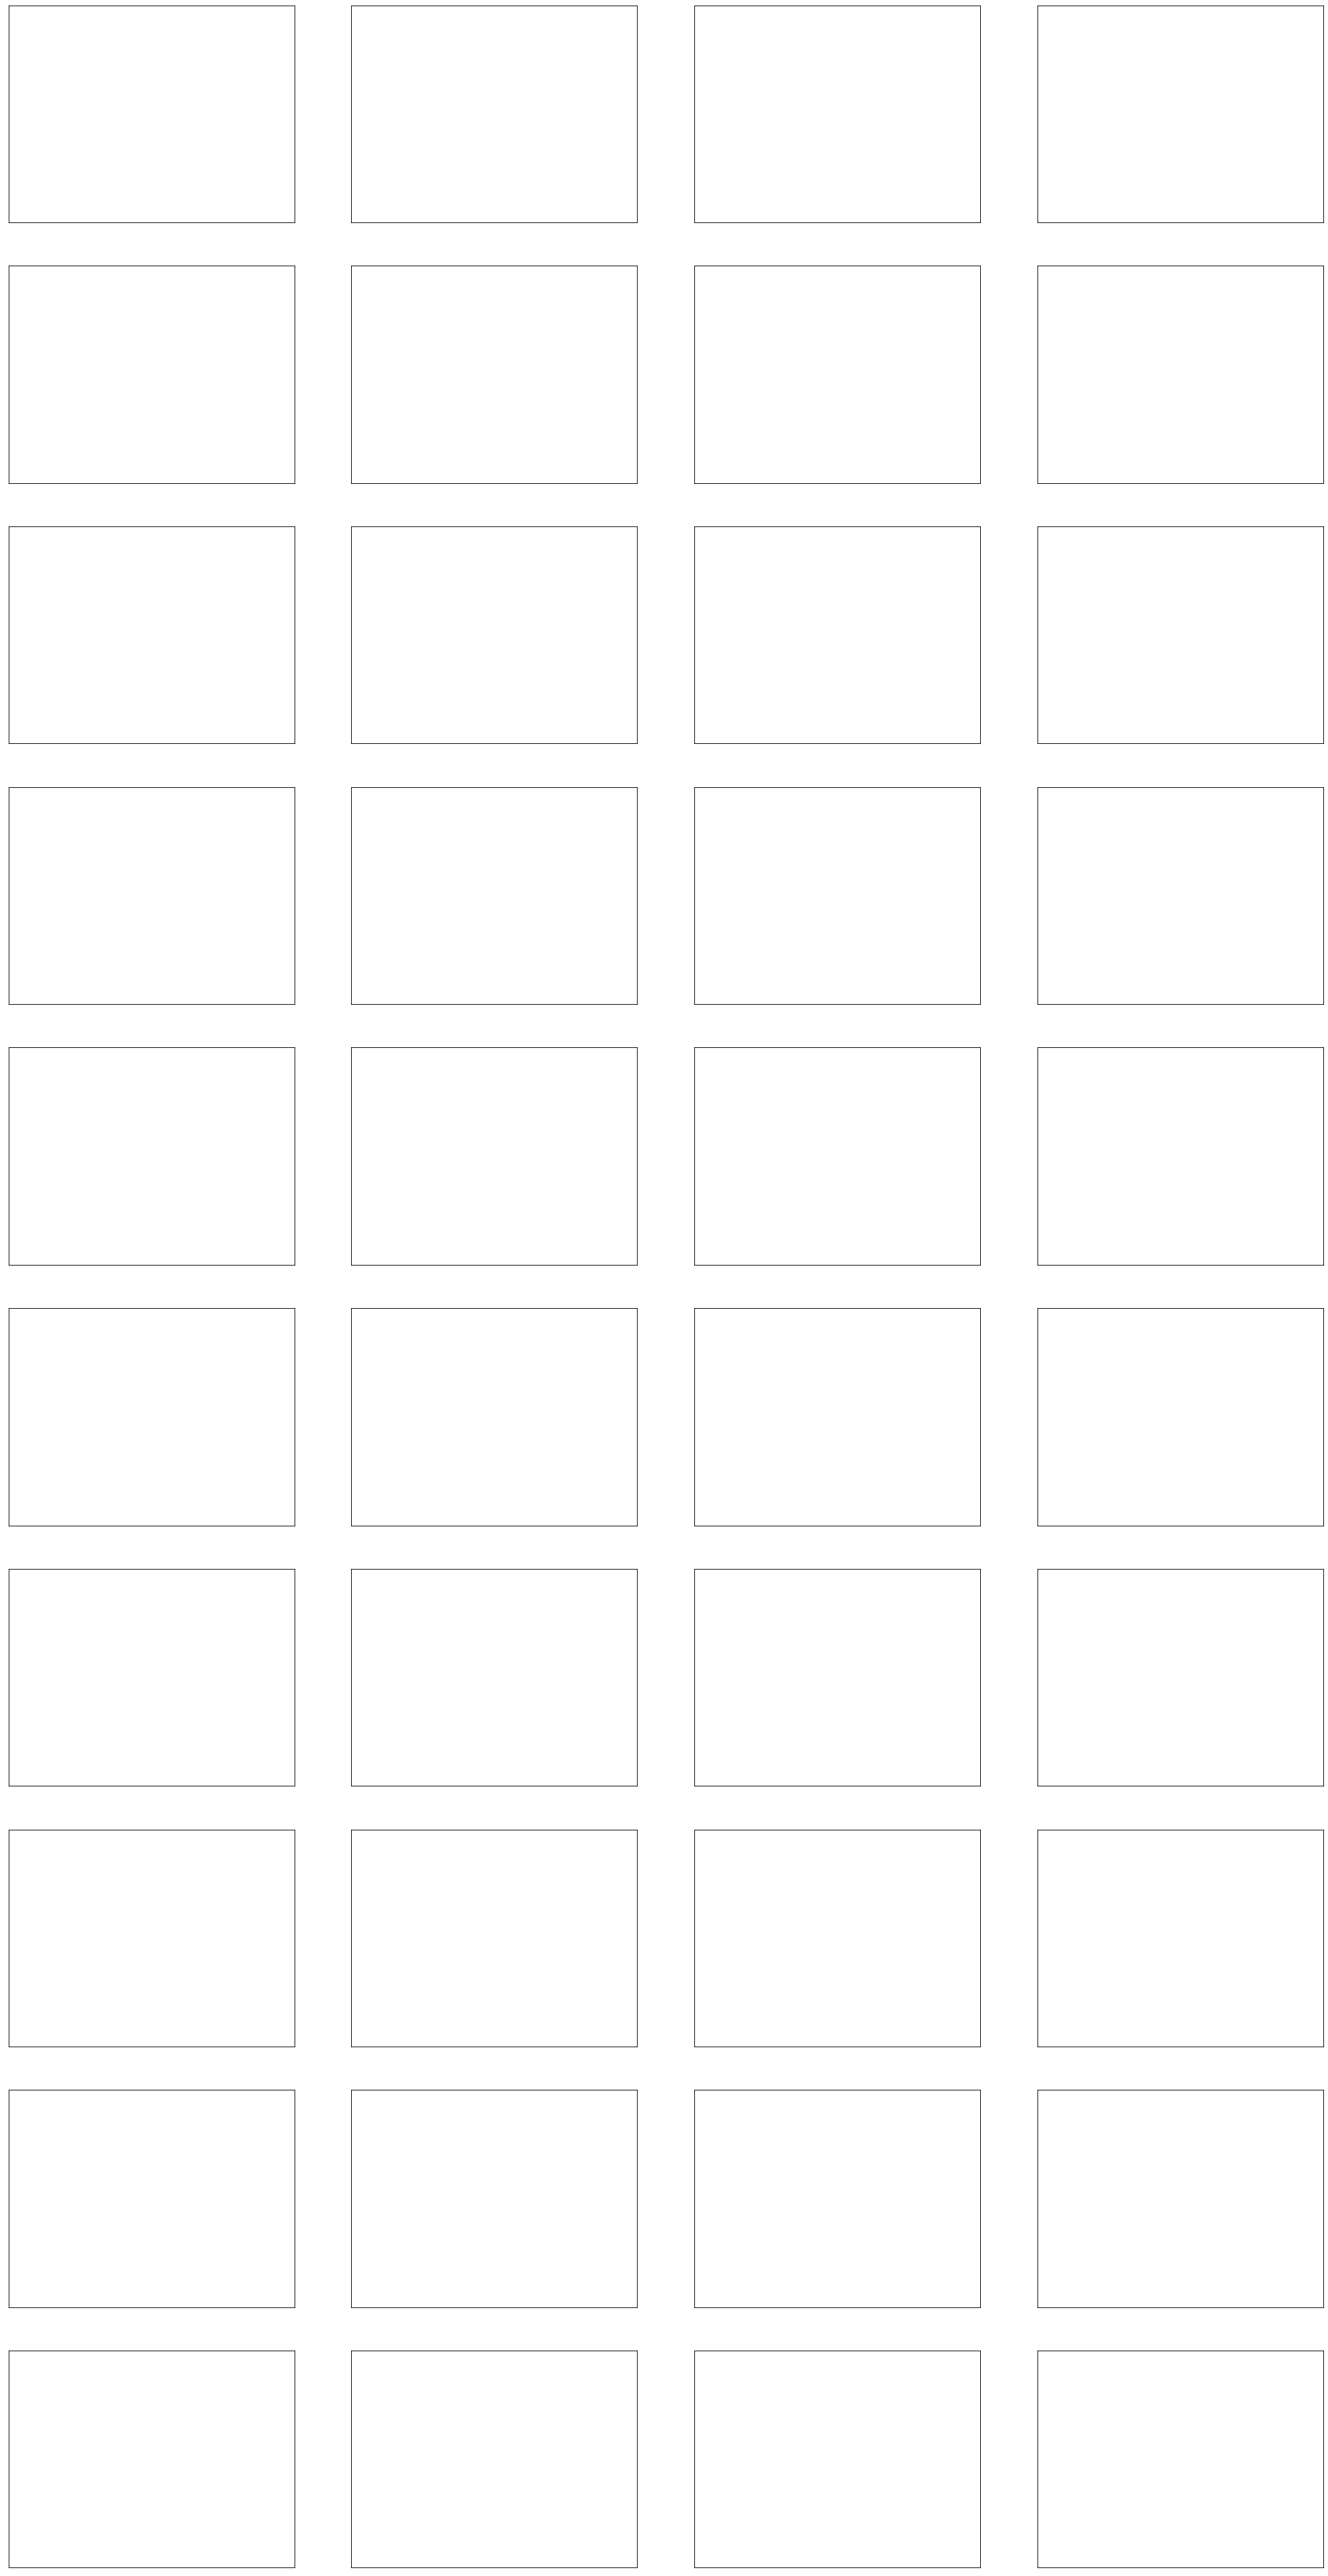

In [48]:
image_filenames = os.listdir(image_dir)
image_filenames.sort(key=imFunc)

valid_ids = [127, 255]
mask_filenames = os.listdir(mask_dir)
mask_filenames.sort(key=maskFunc)

bg_filenames = os.listdir(bg_dir)
bg_filenames.sort(key=bgFunc)

bg_filenames = bg_filenames[21:]

fig, axs = plt.subplots(nrows=10, ncols=4, figsize=(30, 60),
                        subplot_kw={'xticks': [], 'yticks': []})

#filenames = zip(axs, image_filenames[1::5][:10], mask_filenames[1::5][:10], bg_filenames[1::5][:10])
#filenames = zip(axs, image_filenames, mask_filenames, bg_filenames)
filenames = zip(image_filenames, mask_filenames, bg_filenames)

vid_idx_list = []

is_vid = False
start_idx = 0
for i, (image_filename, mask_filename, bg_filename)  in enumerate(filenames):
    frame_image = cv2.imread(os.path.join(image_dir, image_filename))
    frame_mask = cv2.imread(os.path.join(mask_dir, mask_filename), 0)
    
    frame_mask[frame_mask==valid_ids[0]] = 1
    frame_mask[frame_mask==valid_ids[1]] = 2
    
    blobs_labels = measure.label(frame_mask, background=0)
    #print(np.unique(blobs_labels))
    #print(np.sum(frame_mask==1), np.sum(frame_mask==2))
    
    if np.sum(frame_mask==1)> 0 and np.sum(frame_mask==2)>0:
        if not is_vid:
            start_idx = i
            is_vid = True
    else:
        if is_vid:
            vid_idx_list.append((start_idx, i))
            is_vid = False
            
if is_vid:
    vid_idx_list.append((start_idx, i+1))
    
#print(vid_idx_list)
vid_idx_list = [vid_idx for vid_idx in vid_idx_list if (vid_idx[1] - vid_idx[0] > 5)]
#print(vid_idx_list)
        
    
    #ax[3].imshow(dilated_one_rat_image)    

#plt.tight_layout()
#plt.show()

In [49]:

if not os.path.exists(video_dir):
    os.mkdir(video_dir)
    
if not os.path.exists(video_mask_dir):
    os.mkdir(video_mask_dir)
    


In [89]:
def augment_frame(frame_image, frame_mask, frame_bg):
    frame_mask[frame_mask==valid_ids[0]] = 1
    frame_mask[frame_mask==valid_ids[1]] = 2
    
    dilated_frame_mask = dilation(frame_mask, square(15))    
    
    center_rat_1 = ndimage.measurements.center_of_mass(frame_mask==1)
    center_rat_2 = ndimage.measurements.center_of_mass(frame_mask==2)    
    move =  (int(center_rat_2[0] - center_rat_1[0]), int(center_rat_2[1] - center_rat_1[1]))    
    
    moved_mask = (frame_mask==1)    
    whr0, whr1 = np.where(moved_mask)   
    
    d = min(0, moved_mask.shape[0] - (move[0] + max(whr0) + 1))
    
    move = (move[0] + d, move[1])    
    whr0 = whr0 + move[0]
    whr1 = whr1 + move[1]
    
    moved_mask[...] = 0    
    moved_mask[whr0, whr1] = 1
    
    #ax[0].imshow(frame_image)
    #ax[1].imshow(frame_mask)
    
    new_mask = np.zeros_like(frame_mask)
    
    new_mask[frame_mask==2] = 2
    new_mask[moved_mask==1] = 1 
    #ax[2].imshow(new_mask)
    
    dilated_one_rat_image = frame_image.copy()    
    dilated_one_rat_image[dilated_frame_mask==1] = frame_bg[dilated_frame_mask==1]  
    dilated_one_rat_image[moved_mask==1] = frame_image[frame_mask==1]
    
    #### blur
    blurred_img = cv2.GaussianBlur(dilated_one_rat_image, (9, 9), 0)
    blur_moved_mask = moved_mask.copy().astype(np.uint8)
    #blur_moved_mask = np.stack((blur_moved_mask,blur_moved_mask, blur_moved_mask), axis=2)
    contours, hierarchy = cv2.findContours(blur_moved_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cv2.drawContours(blur_moved_mask, contours, -1, (2),2)
    blur_moved_mask = np.stack((blur_moved_mask,blur_moved_mask, blur_moved_mask), axis=2)
    dilated_one_rat_image = np.where(blur_moved_mask==np.array([2, 2, 2]), blurred_img, dilated_one_rat_image)
    
    return new_mask, dilated_one_rat_image

In [141]:
def coco_segm(gt_mask):
    ground_truth_binary_mask = gt_mask.astype(np.uint8)
    fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
    encoded_mask = mask.encode(fortran_ground_truth_binary_mask)

    area = mask.area(encoded_mask)
    bounding_box = mask.toBbox(encoded_mask)
    encoded_mask['counts'] = encoded_mask['counts'].decode('ascii')
    
    return encoded_mask, area.tolist(), bounding_box.tolist()
    

In [142]:
rat_info = dict(description= 'Rats', url= 'https://rats.org/home', version= '0.1', year= 2020, contributor= 'ELTE', date_created= '2020-01-11 00:55:41.903634')
rat_licenses = [dict(url= 'https://creativecommons.org/licenses/by/4.0/', id= 1, name= 'Creative Commons Attribution 4.0 License')]
rat_categories = [dict(supercategory= 'object', id= 1, name ='rat')]
rat_data = dict(info=rat_info, 
                licenses=rat_licenses,
                categories=rat_categories,
                videos=[],
                annotations=[])


ann_id = 0
for v, vid_idx in enumerate(vid_idx_list):
    
    video = dict(width= 640,
                 length= vid_idx[1]-vid_idx[0],
                 date_captured= '',
                 license= '',
                 flickr_url= '',
                 file_names= [],
                 id= v,
                 coco_url= '',
                 height=420)
    
    aug_video = video.copy()
    aug_vid_id = v + len(vid_idx_list)
    aug_video['id'] = aug_vid_id
    
    ann_rat_1 = dict(height= 420,
                     width= 640,
                     length= 1,
                     category_id= 1,
                     segmentations= [],
                     bboxes= [],
                     video_id= v,
                     iscrowd= False,
                     id= ann_id,
                     areas= [])
    
    ann_rat_2 = ann_rat_1.copy()
    ann_rat_2['id'] = ann_id + 1
    
    aug_ann_rat_1 = ann_rat_1.copy()
    aug_ann_rat_1['id'] = ann_id + 2
    aug_ann_rat_1['video_id'] = aug_vid_id
    
    aug_ann_rat_2 = aug_ann_rat_1.copy()
    aug_ann_rat_2['id'] = ann_id + 3
    
    ann_id += 4
    
    vid_path = os.path.join(video_dir, str(v))
    if not os.path.exists(vid_path):
        os.mkdir(vid_path)
    vid_mask_path=os.path.join(video_mask_dir, str(v))
    if not os.path.exists(vid_mask_path):
        os.mkdir(vid_mask_path)
        
    aug_vid_path = os.path.join(video_dir, 'aug_{}'.format(v))
    if not os.path.exists(aug_vid_path):
        os.mkdir(aug_vid_path)
    aug_vid_mask_path=os.path.join(video_mask_dir, 'aug_{}'.format(v))
    if not os.path.exists(aug_vid_mask_path):
        os.mkdir(aug_vid_mask_path)
        
    video_files = zip(image_filenames[vid_idx[0]:vid_idx[1]], mask_filenames[vid_idx[0]:vid_idx[1]], bg_filenames[vid_idx[0]:vid_idx[1]])
    for f, (image_filename, mask_filename, bg_filename) in enumerate(video_files):    
        #print(image_filename, mask_filename, bg_filename)
        frame_image = cv2.imread(os.path.join(image_dir, image_filename))
        frame_mask = cv2.imread(os.path.join(mask_dir, mask_filename), 0)
        frame_bg = cv2.imread(os.path.join(bg_dir, bg_filename))
        
        
        video['file_names'].append(os.path.join(str(v), '{}.png'.format(f)))
        
        encoded_mask, area, bbox = coco_segm(frame_mask==valid_ids[0])
        ann_rat_1['segmentations'].append(encoded_mask)
        ann_rat_1['bboxes'].append(bbox)
        ann_rat_1['areas'].append(area)
        
        encoded_mask, area, bbox = coco_segm(frame_mask==valid_ids[1])
        ann_rat_2['segmentations'].append(encoded_mask)
        ann_rat_2['bboxes'].append(bbox)
        ann_rat_2['areas'].append(area)
        
        cv2.imwrite(os.path.join(vid_path, '{}.png'.format(f)), frame_image)
        cv2.imwrite(os.path.join(vid_mask_path, '{}.png'.format(f)), frame_mask)
        
        new_mask, dilated_one_rat_image = augment_frame(frame_image, frame_mask, frame_bg)
        
        encoded_mask, area, bbox = coco_segm(new_mask==1)
        aug_ann_rat_1['segmentations'].append(encoded_mask)
        aug_ann_rat_1['bboxes'].append(bbox)
        aug_ann_rat_1['areas'].append(area)
        
        encoded_mask, area, bbox = coco_segm(new_mask==2)
        aug_ann_rat_2['segmentations'].append(encoded_mask)
        aug_ann_rat_2['bboxes'].append(bbox)
        aug_ann_rat_2['areas'].append(area)
        
        new_mask[new_mask==1] = valid_ids[0]
        new_mask[new_mask==2] = valid_ids[1]
        
        aug_video['file_names'].append(os.path.join('aug_{}'.format(v), '{}.png'.format(f)))
        cv2.imwrite(os.path.join(aug_vid_path, '{}.png'.format(f)), dilated_one_rat_image)
        cv2.imwrite(os.path.join(aug_vid_mask_path, '{}.png'.format(f)), new_mask)
        
    #print('xxxx')
    rat_data['videos'].append(video)
    rat_data['videos'].append(aug_video)
    
    rat_data['annotations'].append(ann_rat_1)
    rat_data['annotations'].append(ann_rat_2)
    rat_data['annotations'].append(aug_ann_rat_1)
    rat_data['annotations'].append(aug_ann_rat_2)
    

In [143]:
with open('/home/fothar/rats/annotations/instances_train.json', 'w') as outfile:
    json.dump(rat_data, outfile)

In [47]:
from mmdet.datasets import build_dataset

from mmdet.datasets.youtube import RatDataset